<a href="https://colab.research.google.com/github/Remonah-3/Github_Assignment/blob/master/Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

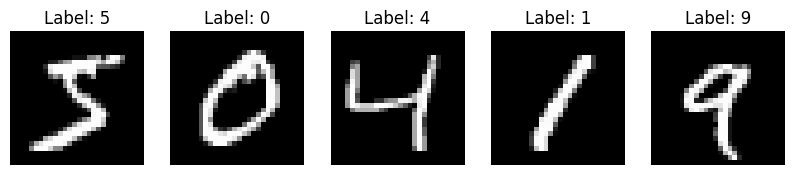


--- Network 1 ---
Epoch 10, Train Loss: 0.0621, Val Loss: 0.5782
Epoch 20, Train Loss: 0.0211, Val Loss: 0.6214
Epoch 30, Train Loss: 0.0118, Val Loss: 0.6417
Epoch 40, Train Loss: 0.0080, Val Loss: 0.6435
Epoch 50, Train Loss: 0.0060, Val Loss: 0.6780


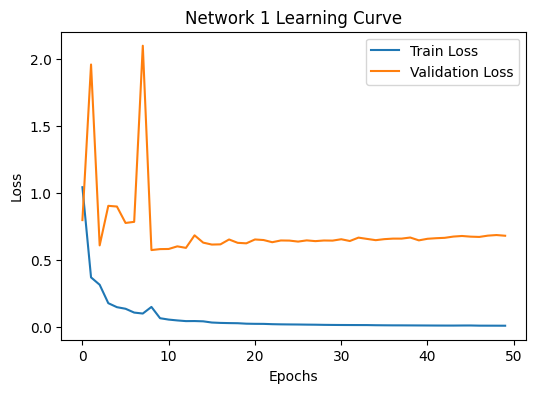

Test Accuracy on 200 samples: 93.50%

--- Network 2 ---
Epoch 10, Train Loss: 0.0607, Val Loss: 0.6194
Epoch 20, Train Loss: 0.0180, Val Loss: 0.5434
Epoch 30, Train Loss: 0.0081, Val Loss: 0.5702
Epoch 40, Train Loss: 0.0049, Val Loss: 0.5816
Epoch 50, Train Loss: 0.0035, Val Loss: 0.6083


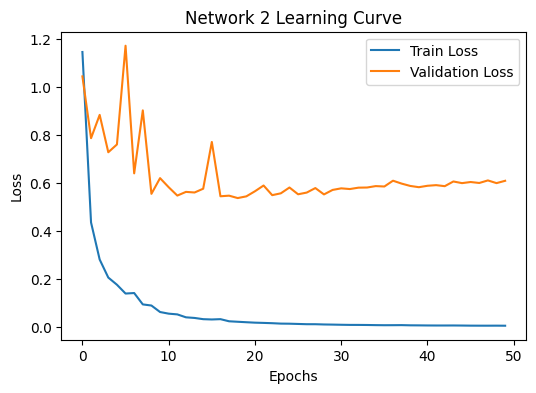

Test Accuracy on 200 samples: 93.50%

--- Network 3 ---
Epoch 10, Train Loss: 0.0733, Val Loss: 0.5674
Epoch 20, Train Loss: 0.0240, Val Loss: 0.5697
Epoch 30, Train Loss: 0.0141, Val Loss: 0.5803
Epoch 40, Train Loss: 0.0085, Val Loss: 0.6062
Epoch 50, Train Loss: 0.0064, Val Loss: 0.6315


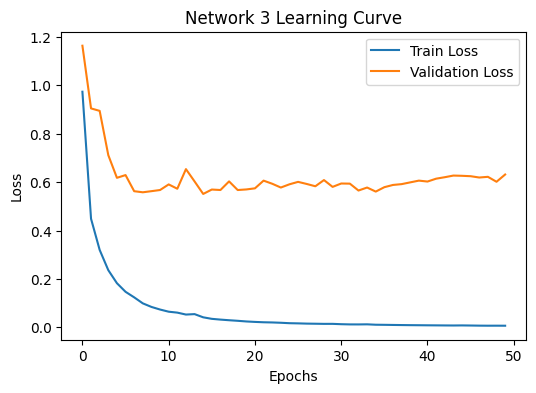

Test Accuracy on 200 samples: 94.00%

--- Network 4 ---
Epoch 10, Train Loss: 0.6117, Val Loss: 0.8073
Epoch 20, Train Loss: 0.4067, Val Loss: 0.6835
Epoch 30, Train Loss: 0.3089, Val Loss: 0.6086
Epoch 40, Train Loss: 0.2549, Val Loss: 0.5695
Epoch 50, Train Loss: 0.2157, Val Loss: 0.5575


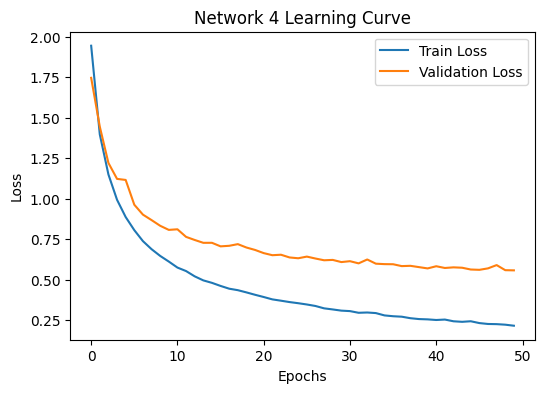

Test Accuracy on 200 samples: 90.00%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Fully Connected Layer (FC)

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.W = initializer.initialize_weights((n_nodes1, n_nodes2))
        self.B = initializer.initialize_bias((1, n_nodes2))
        self.X = None

    def forward(self, X):
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        dW = np.dot(self.X.T, dA) / self.X.shape[0]
        dB = np.mean(dA, axis=0, keepdims=True)
        dZ = np.dot(dA, self.W.T)
        self.dW = dW
        self.dB = dB
        self = self.optimizer.update(self)
        return dZ

# Initializers

class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def initialize_weights(self, shape):
        return np.random.randn(*shape) * self.sigma
    def initialize_bias(self, shape):
        return np.zeros(shape)

class XavierInitializer:
    def initialize_weights(self, shape):
        n_in, n_out = shape
        sigma = 1.0 / np.sqrt(n_in)
        return np.random.randn(n_in, n_out) * sigma
    def initialize_bias(self, shape):
        return np.zeros(shape)

class HeInitializer:
    def initialize_weights(self, shape):
        n_in, n_out = shape
        sigma = np.sqrt(2.0 / n_in)
        return np.random.randn(n_in, n_out) * sigma
    def initialize_bias(self, shape):
        return np.zeros(shape)

# Optimizers

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class AdaGrad:
    def __init__(self, lr=0.01, eps=1e-8):
        self.lr = lr
        self.eps = eps
        self.H_W = {}
        self.H_B = {}
    def update(self, layer):
        if layer not in self.H_W:
            self.H_W[layer] = np.zeros_like(layer.W)
            self.H_B[layer] = np.zeros_like(layer.B)
        self.H_W[layer] += layer.dW ** 2
        self.H_B[layer] += layer.dB ** 2
        layer.W -= self.lr * layer.dW / (np.sqrt(self.H_W[layer]) + self.eps)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.H_B[layer]) + self.eps)
        return layer

# Activation Functions

class Tanh:
    def __init__(self):
        self.Z = None
    def forward(self, Z):
        self.Z = Z
        return np.tanh(Z)
    def backward(self, dA):
        return dA * (1 - np.tanh(self.Z)**2)

class ReLU:
    def __init__(self):
        self.Z = None
    def forward(self, Z):
        self.Z = Z
        return np.maximum(0, Z)
    def backward(self, dA):
        dZ = dA.copy()
        dZ[self.Z <= 0] = 0
        return dZ

class Sigmoid:
    def __init__(self):
        self.Z = None
        self.A = None
    def forward(self, Z):
        self.Z = Z
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    def backward(self, dA):
        return dA * self.A * (1 - self.A)

class Softmax:
    def __init__(self):
        self.Z = None
    def forward(self, Z):
        self.Z = Z
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    def backward(self, A, Y):
        batch_size = Y.shape[0]
        return (A - Y) / batch_size

# Deep Neural Network Classifier

class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, n_features, layer_nodes, activations, initializer, optimizer):
        self.n_features = n_features
        self.layer_nodes = layer_nodes
        self.activations = activations
        self.initializer = initializer
        self.optimizer = optimizer
        self.layers = []
        prev_nodes = n_features
        for i, n_nodes in enumerate(layer_nodes):
            fc = FC(prev_nodes, n_nodes, self.initializer, self.optimizer)
            self.layers.append((fc, activations[i]))
            prev_nodes = n_nodes

    def forward(self, X):
        A = X
        for fc, activation in self.layers:
            Z = fc.forward(A)
            A = activation.forward(Z)
        return A

    def backward(self, Y, output):
        dA = None
        for i in reversed(range(len(self.layers))):
            fc, activation = self.layers[i]
            if isinstance(activation, Softmax):
                dA = activation.backward(output, Y)
            else:
                dA = activation.backward(dA)
            dA = fc.backward(dA)

    # Mini-batch train step
    def train_step(self, X, Y, batch_size=32):
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        losses = []
        for start in range(0, X.shape[0], batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            X_batch = X[batch_idx]
            Y_batch = Y[batch_idx]
            output = self.forward(X_batch)
            self.backward(Y_batch, output)
            loss = -np.mean(np.sum(Y_batch * np.log(output + 1e-9), axis=1))
            losses.append(loss)
        return np.mean(losses)

    # Train for multiple epochs with mini-batch
    def fit(self, X_train, Y_train, X_val=None, Y_val=None, epochs=100, batch_size=32, verbose=True):
        train_losses = []
        val_losses = []
        for epoch in range(1, epochs+1):
            loss = self.train_step(X_train, Y_train, batch_size)
            train_losses.append(loss)
            if X_val is not None and Y_val is not None:
                output_val = self.forward(X_val)
                val_loss = -np.mean(np.sum(Y_val * np.log(output_val + 1e-9), axis=1))
                val_losses.append(val_loss)
            if verbose and epoch % 10 == 0:
                msg = f"Epoch {epoch}, Train Loss: {loss:.4f}"
                if X_val is not None:
                    msg += f", Val Loss: {val_loss:.4f}"
                print(msg)
        return train_losses, val_losses

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

# Load MNIST and display sample images

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

# Display 5 MNIST images
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Multiple network configurations

configs = [
    {'layers': [128, 64, 10], 'activations': [ReLU(), ReLU(), Softmax()]},
    {'layers': [64, 64, 64, 10], 'activations': [ReLU(), ReLU(), ReLU(), Softmax()]},
    {'layers': [256, 128, 64, 10], 'activations': [Tanh(), Tanh(), Tanh(), Softmax()]},
    {'layers': [128, 64, 10], 'activations': [Sigmoid(), Sigmoid(), Softmax()]}
]

# Train and evaluate each network
for idx, cfg in enumerate(configs):
    print(f"\n--- Network {idx+1} ---")
    initializer = HeInitializer() if isinstance(cfg['activations'][0], ReLU) else XavierInitializer()
    optimizer = AdaGrad(lr=0.01)
    model = ScratchDeepNeuralNetworkClassifier(
        n_features=28*28,
        layer_nodes=cfg['layers'],
        activations=cfg['activations'],
        initializer=initializer,
        optimizer=optimizer
    )

    # Use a small subset for faster demo
    X_val = X_train[1000:1200]
    Y_val = Y_train[1000:1200]
    X_train_small = X_train[:1000]
    Y_train_small = Y_train[:1000]

    # Train
    train_losses, val_losses = model.fit(
        X_train_small, Y_train_small,
        X_val, Y_val,
        epochs=50, batch_size=32, verbose=True
    )

    # Plot learning curve per network
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Network {idx+1} Learning Curve')
    plt.legend()
    plt.show()

    # Evaluate test accuracy on first 200 test samples
    pred = model.predict(X_test[:200])
    acc = accuracy(y_test[:200], pred)
    print(f"Test Accuracy on 200 samples: {acc*100:.2f}%")
